In [1]:
# Cell 0 - Preparation: load packages, set some basic options  
%matplotlib inline
import obspy
from obspy.signal.invsim import cosine_taper 
from obspy.signal.filter import lowpass
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime
from matplotlib import rcParams
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15, 7
rcParams["figure.subplot.hspace"] = (0.5)

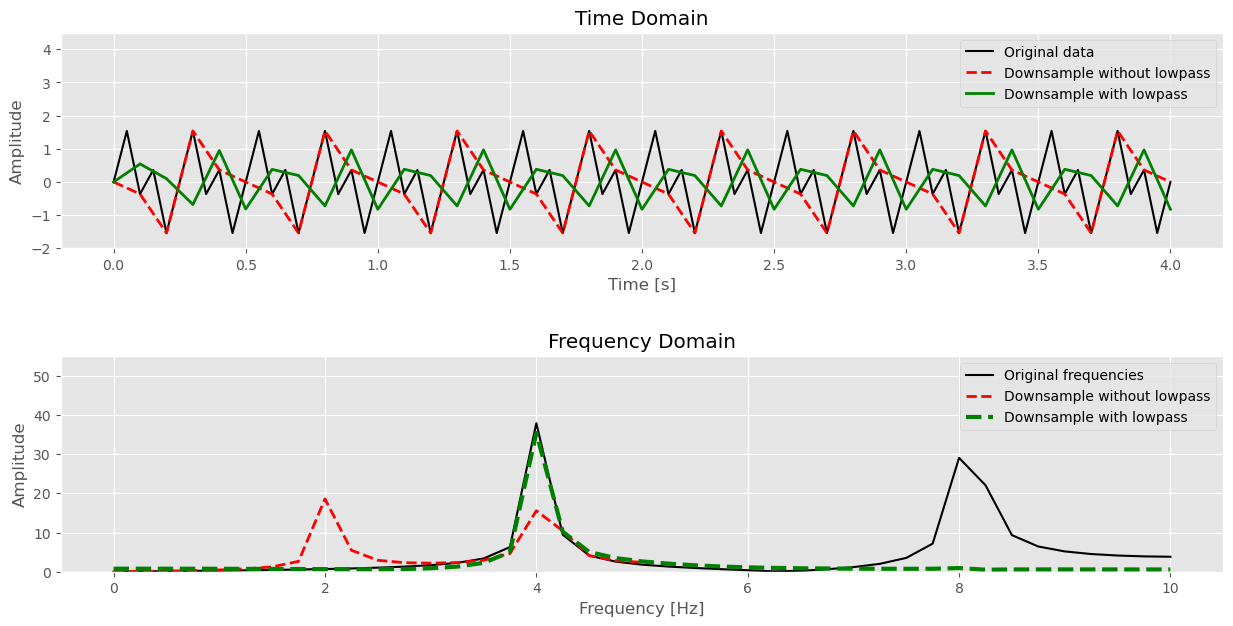

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Cell 1: downsampling + Nyquist
npts = 512                              # number of samples
nsec = 4.0                              # length of signal in seconds
df = 20.0                               # sampling rate
fNy = df / 2.0                          # Nyquist frequency
fg1 = 8                                 # generator frequency 1 (initial: 8 Hz)
fg2 = 4                                 # generator frequency 2 (initial: 4 Hz)
time = np.linspace(0, nsec, int(nsec * df) + 1)  # time axis for plotting

y  = np.sin(2 * np.pi * fg1 * time)     # set up a test signal from two frequencies
y += np.sin(2 * np.pi * fg2 * time) 

# downsample to 10 Hz by taking every second element
y_2 = y[::2]

# downsample after lowpassing the signal
# Assure-toi que la fonction lowpass est définie ou importée correctement
y_l = lowpass(y, 5.0, df=df, corners=4, zerophase=False)  # à adapter si nécessaire
y_new = y_l[::2]

y_f = np.fft.rfft(y)                    # transform all 3 signals into frequency domain 
y_f2 = np.fft.rfft(y_2)                 # applying Fourier transformation via FFT
y_fnew = np.fft.rfft(y_l)
freq = np.linspace(0, fNy, len(y_f))    # frequency axis for plotting

# plot
plt.subplot(211)
plt.plot(time, y, 'k', label="Original data", lw=1.5)
plt.plot(time[::2], y_2, 'r--', label="Downsample without lowpass", lw=2)
plt.plot(time[::2], y_new, 'g', label="Downsample with lowpass", lw=2)
plt.legend()
plt.ylim(-2, 4.5)
plt.title('Time Domain')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(212)
plt.plot(freq, abs(y_f), 'k', label="Original frequencies", lw=1.5)
plt.plot(freq[:len(y_f2)], abs(y_f2), 'r--', label="Downsample without lowpass", lw=2)
plt.plot(freq[:len(y_fnew)], abs(y_fnew), 'g--', label="Downsample with lowpass", lw=3)
plt.legend()
plt.ylim(0, 55)
plt.title('Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

plt.show()


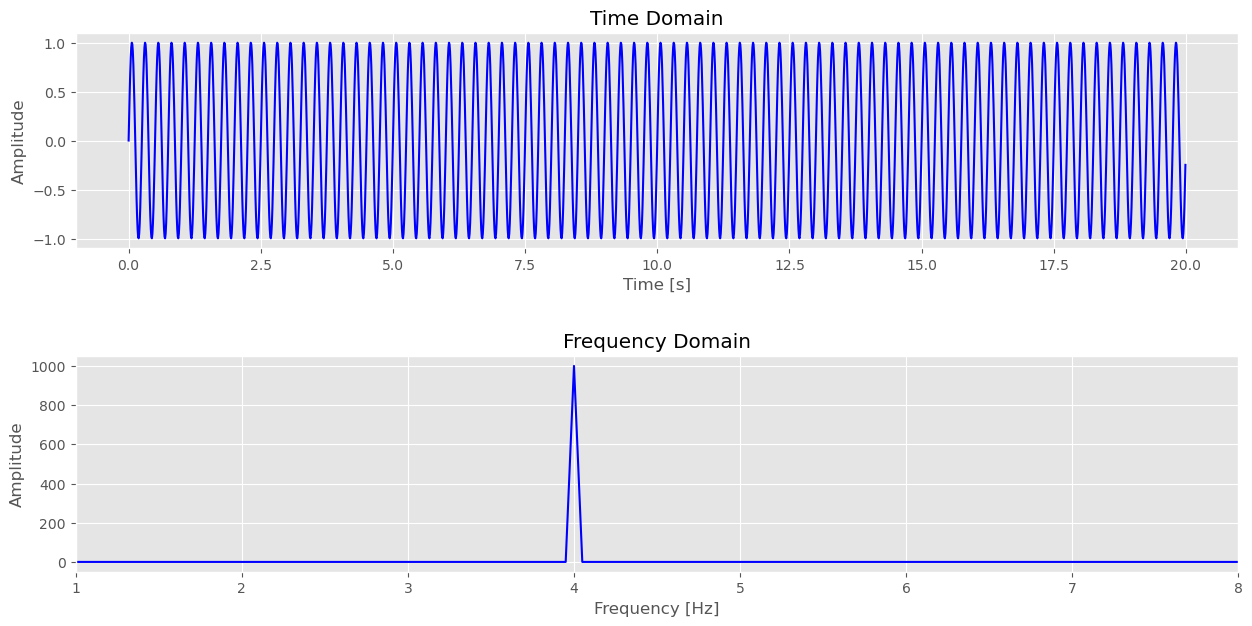

In [5]:
# Cell 2: spectral leakage
leng = 20.0                           # length of signal in seconds (initial: 2 s)
dt = 1./100.                         # sampling interval
ny = 1/(2.*dt)                       # Nyquist frequency
t = np.arange(0, leng, dt)           # time axis for plotting
sin  = np.sin(2 * 4 * np.pi * t)     # set up a sine wave as signal

Fsin = np.fft.rfft(sin)              # FFT to frequency domain
f = np.linspace(0, ny, len(Fsin))    # frequency axis for plotting

# plot
plt.subplot(211)
plt.plot(t, sin, 'b')
plt.title('Time Domain')
plt.ylim(-1.1,1.1)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(212)
plt.plot(f, abs(Fsin), 'b')
plt.xlim(1,8)
plt.title('Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

plt.show()

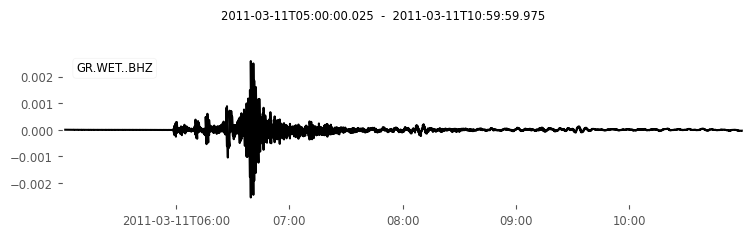

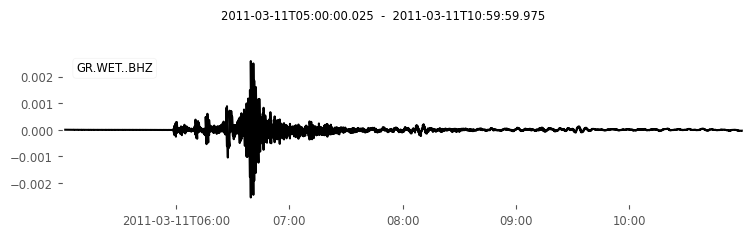

In [6]:
# Cell 3: prepare data from Tohoku earthquake. 
client = Client("BGR")
t1 = UTCDateTime("2011-03-11T05:00:00.000")
st = client.get_waveforms("GR", "WET", "", "BHZ", t1, t1 + 6 * 60 * 60, 
                          attach_response = True)
st.remove_response(output="VEL")
st.detrend('linear')
st.detrend('demean')
st.plot()